In [220]:
import torch
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import data_processing, visualization, statistic, HI_VAE_functions
import time
import pandas as pd
import warnings
from lifelines import CoxPHFitter
from tableone import TableOne
warnings.filterwarnings("ignore")

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.compare import compare_survival
from sksurv.nonparametric import kaplan_meier_estimator

from sksurv.util import Surv

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [221]:
%matplotlib inline

### Experiment setting

In [222]:
dataset_name = "gbsg2"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "./dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

In [223]:
gbsb2_control = pd.read_csv(data_file_control,header=None)
gbsb2_control.columns = ['time','censor','age','estrec','menostat','pnodes','progrec','tgrade','tsize']

In [224]:
gbsb2_control_columns = pd.read_csv(feat_types_file_control)["name"].to_list()[1:]
gbsb2_control_columns.insert(0, 'censor')
gbsb2_control_columns.insert(0, 'time')

### Data loading and Feature analysis treated/control

In [225]:
# Load training data
data_control, feat_types_dict, miss_mask_control, true_miss_mask_control, n_samples_control = data_processing.read_data(data_file_control, 
                                                                                                                        feat_types_file_control, 
                                                                                                                        miss_file, true_miss_file)
# Feature analysis
data_transformed_control = data_processing.discrete_variables_transformation(data_control, feat_types_dict)


In [226]:
# Load training data
data_treated, feat_types_dict, miss_mask_treated, true_miss_mask_treated, n_samples_treated = data_processing.read_data(data_file_treated, 
                                                                                                                        feat_types_file_treated, 
                                                                                                                        miss_file, true_miss_file)

# Feature analysis
data_transformed_treated = data_processing.discrete_variables_transformation(data_treated, feat_types_dict)


In [227]:
df_transformed_treated = pd.DataFrame(data_transformed_treated.numpy(), columns=gbsb2_control_columns)
df_transformed_control = pd.DataFrame(data_transformed_control.numpy(), columns=gbsb2_control_columns)
df_transformed_treated["treatment"]=1
df_transformed_control["treatment"]=0
df_transformed_all = pd.concat([df_transformed_control, df_transformed_treated], ignore_index=True)

In [228]:
feat_types_dict_all = feat_types_dict.copy()#

comparison variable treatment 9


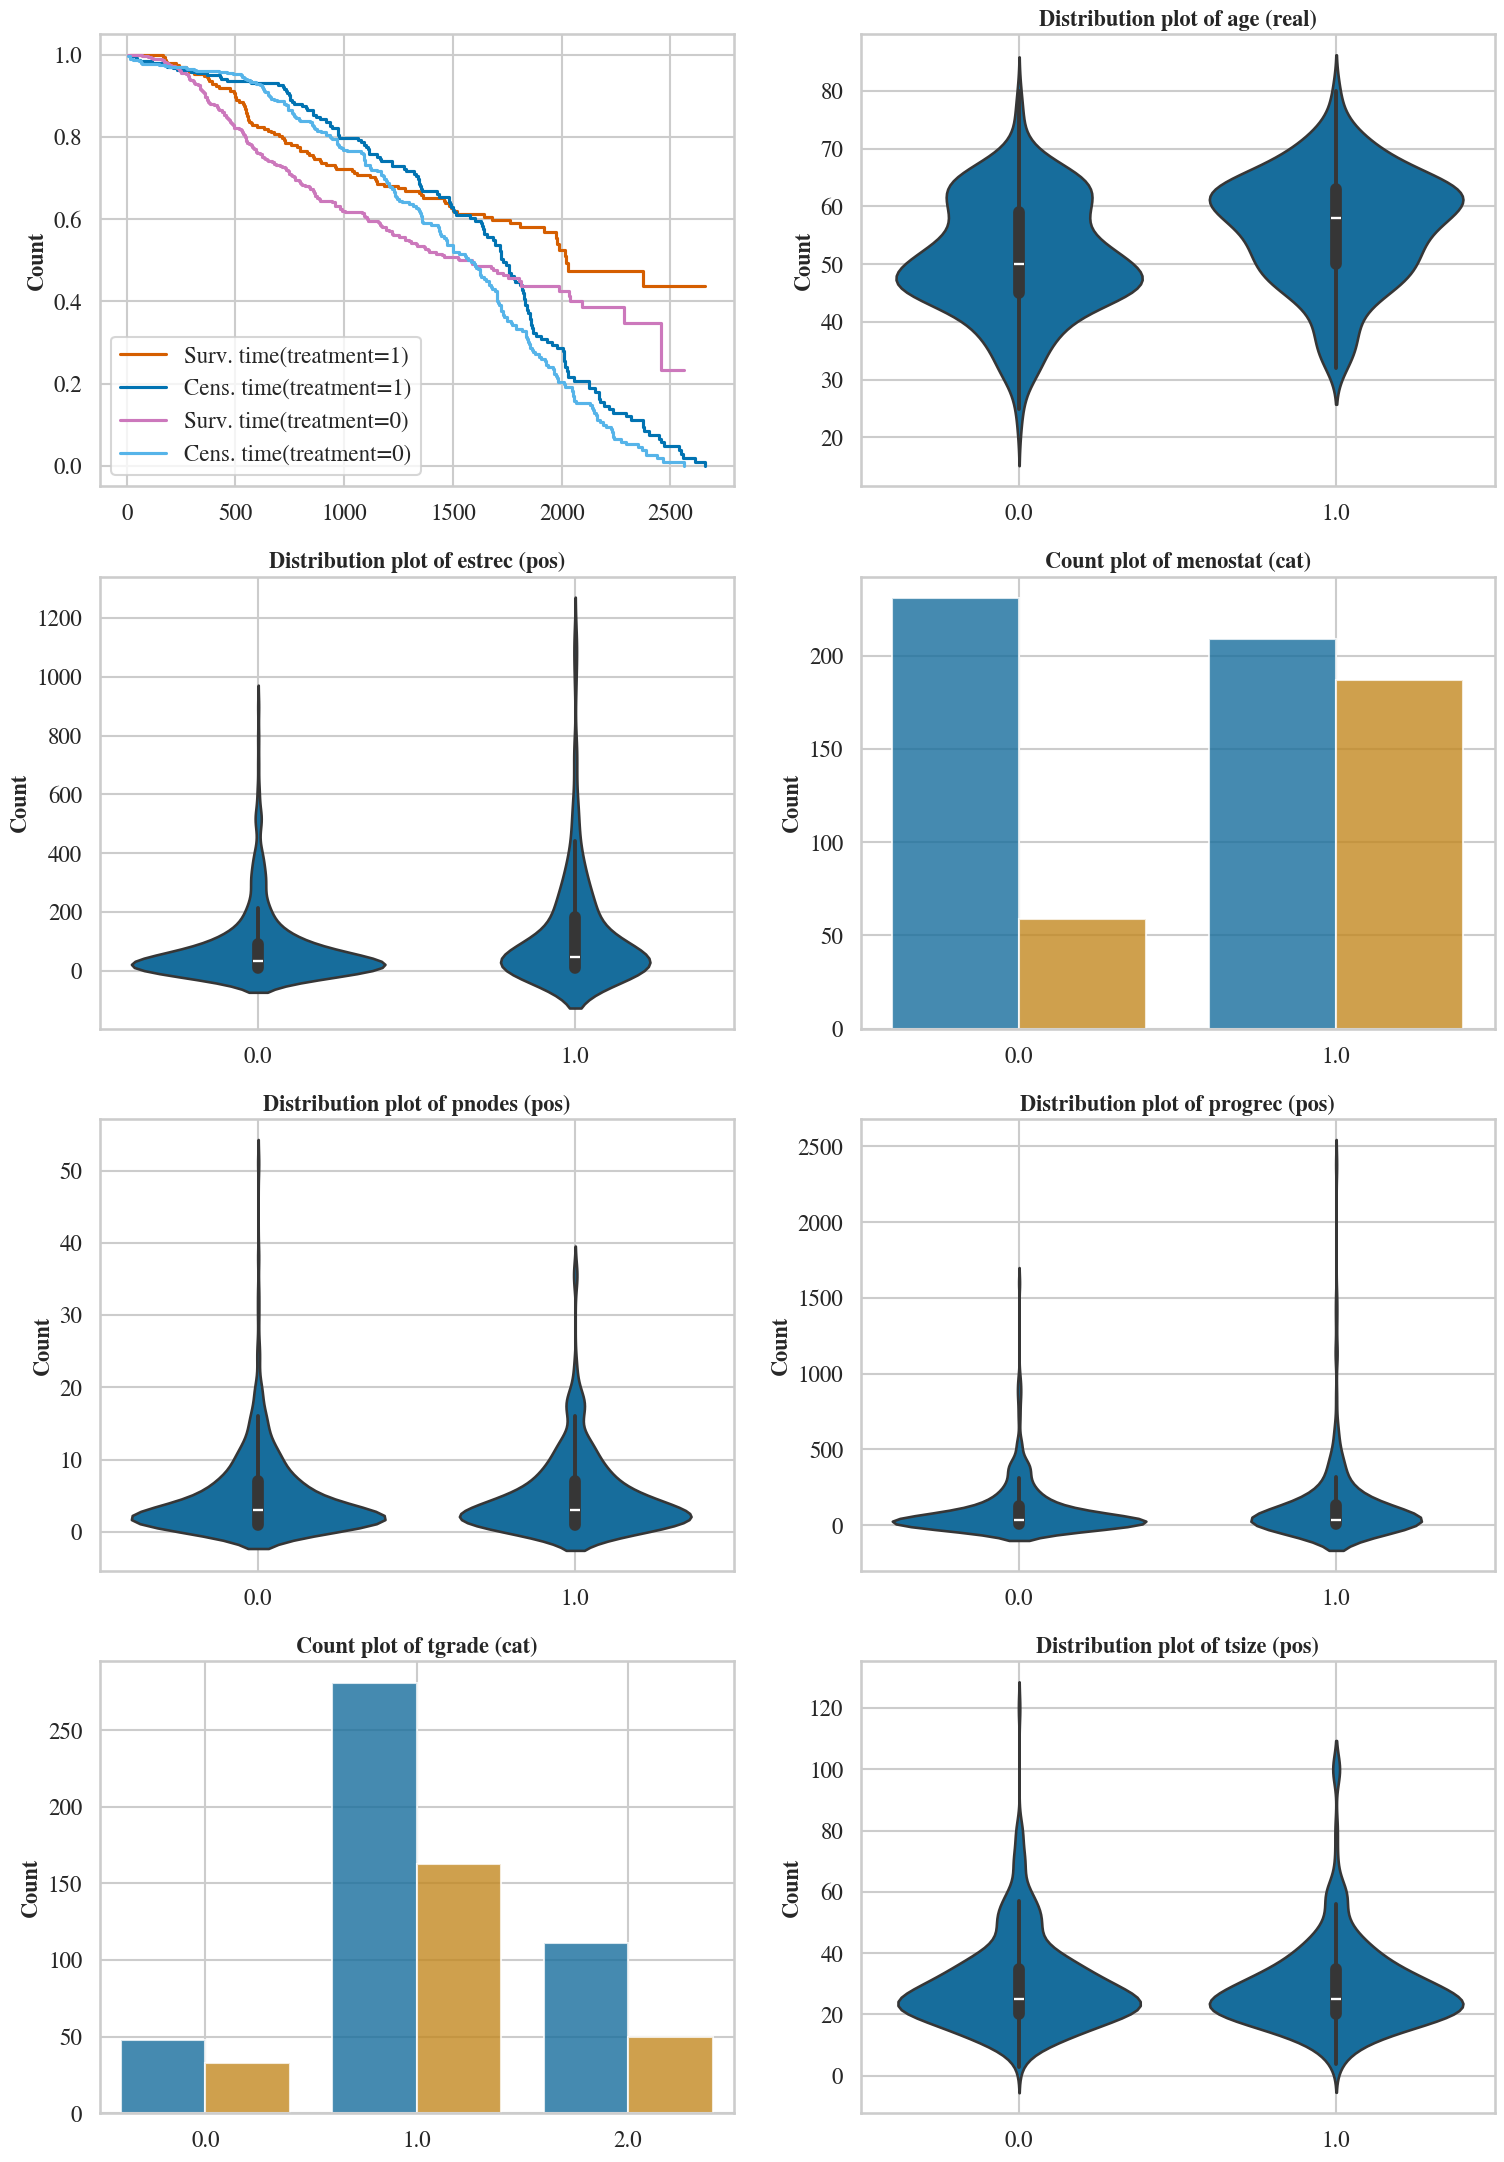

In [229]:
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_all.to_numpy(),feat_types_dict_all,feat_comparison_name = 'treatment')

In [230]:
categorical = ['censor','menostat', 'tgrade','treatment']
continuous = ['time', 'estrec', 'pnodes','progrec', 'tsize', 'age']
nonnormal = ['time', 'estrec', 'pnodes','progrec', 'tsize', 'age']

In [231]:
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                            Grouped by treatment                                                                            
                                         Missing                Overall                     0                      1 P-Value
n                                                                   686                   440                    246        
time, median [Q1,Q3]                           0  1084.0 [567.8,1684.8]  967.0 [547.8,1573.0]  1220.5 [695.8,1818.0]   0.001
censor, n (%)           0.0                                  387 (56.4)            235 (53.4)             152 (61.8)   0.041
                        1.0                                  299 (43.6)            205 (46.6)              94 (38.2)        
age, median [Q1,Q3]                            0       53.0 [46.0,61.0]      50.0 [45.0,59.0]       58.0 [50.0,63.0]  <0.001
estrec, median [Q1,Q3]                         0       36.0 [8.0,114.0]       32.0 [8.0,92.2]       46.0 [9.0,182.5]   0.009


## Training VAE

### Experiment setting

Epoch: [ 0]  time: 0.1212, ELBO_train: -26.70063400, KL_z: 1.41405920, KL_s: 0.10012174, reconstruction loss: -25.18645306
Epoch: [100]  time: 4.1642, ELBO_train: -24.27017466, KL_z: 0.80422461, KL_s: 0.03290232, reconstruction loss: -23.43304773
Epoch: [200]  time: 7.7477, ELBO_train: -24.09064293, KL_z: 0.95835771, KL_s: 0.02967246, reconstruction loss: -23.10261275
Epoch: [300]  time: 11.3459, ELBO_train: -24.15237745, KL_z: 1.05514709, KL_s: 0.02807466, reconstruction loss: -23.06915569
Epoch: [400]  time: 15.4526, ELBO_train: -24.10928981, KL_z: 1.14439881, KL_s: 0.02941243, reconstruction loss: -22.93547857
Epoch: [500]  time: 19.5064, ELBO_train: -24.02009074, KL_z: 1.22244024, KL_s: 0.03059228, reconstruction loss: -22.76705821
Epoch: [600]  time: 23.1031, ELBO_train: -24.07648849, KL_z: 1.22640880, KL_s: 0.03060961, reconstruction loss: -22.81947009
Epoch: [700]  time: 27.1932, ELBO_train: -23.87943204, KL_z: 1.26938975, KL_s: 0.02952115, reconstruction loss: -22.58052115
Epoc

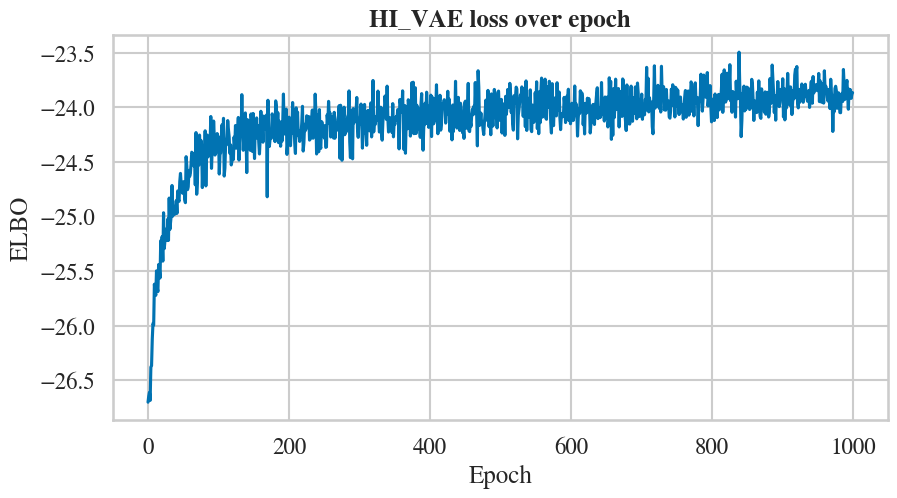

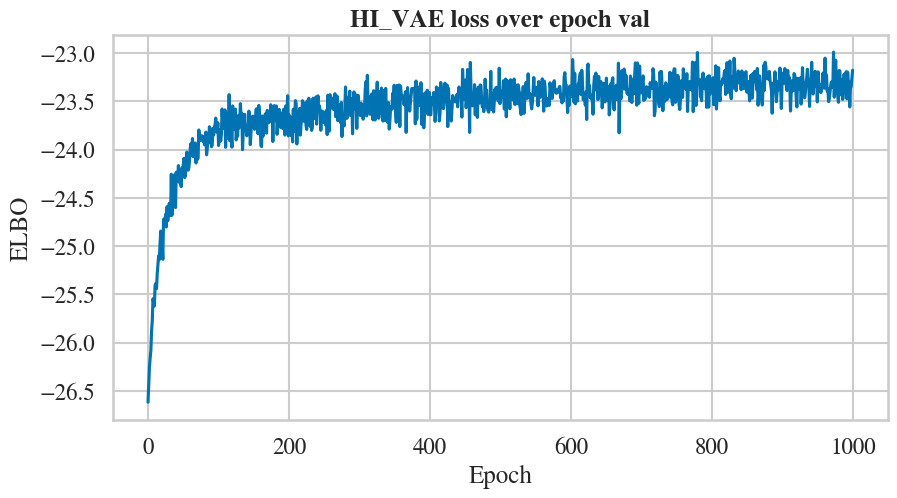

In [232]:

vae_model = HI_VAE_functions.HI_VAE_model(data = data_control, miss_mask = miss_mask_control, true_miss_mask = true_miss_mask_control, 
                                          feat_types_file = feat_types_file_control,feat_types_dict = feat_types_dict,
                                          dataset_name = dataset_name, m_perc = m_perc, mask = mask)


In [233]:

est_data_gen_transformed = HI_VAE_functions.HI_VAE_generation(vae_model = vae_model, data_forgen = data_control, 
                                                              feat_types_dict = feat_types_dict, miss_mask_forgen = miss_mask_control,
                                                              true_miss_mask_forgen = true_miss_mask_control, n_batches_generation = 1, 
                                                              n_generated_sample = 100)


440


In [234]:
df_transformed_initial = pd.DataFrame(data_transformed_control.numpy(), columns=gbsb2_control_columns)
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[3].numpy(), columns=gbsb2_control_columns)
df_transformed_initial["sample"]=1
df_transformed_generated["sample"]=0
df_transformed_initial_generated = pd.concat([df_transformed_initial, df_transformed_generated], ignore_index=True)

comparison variable sample 9


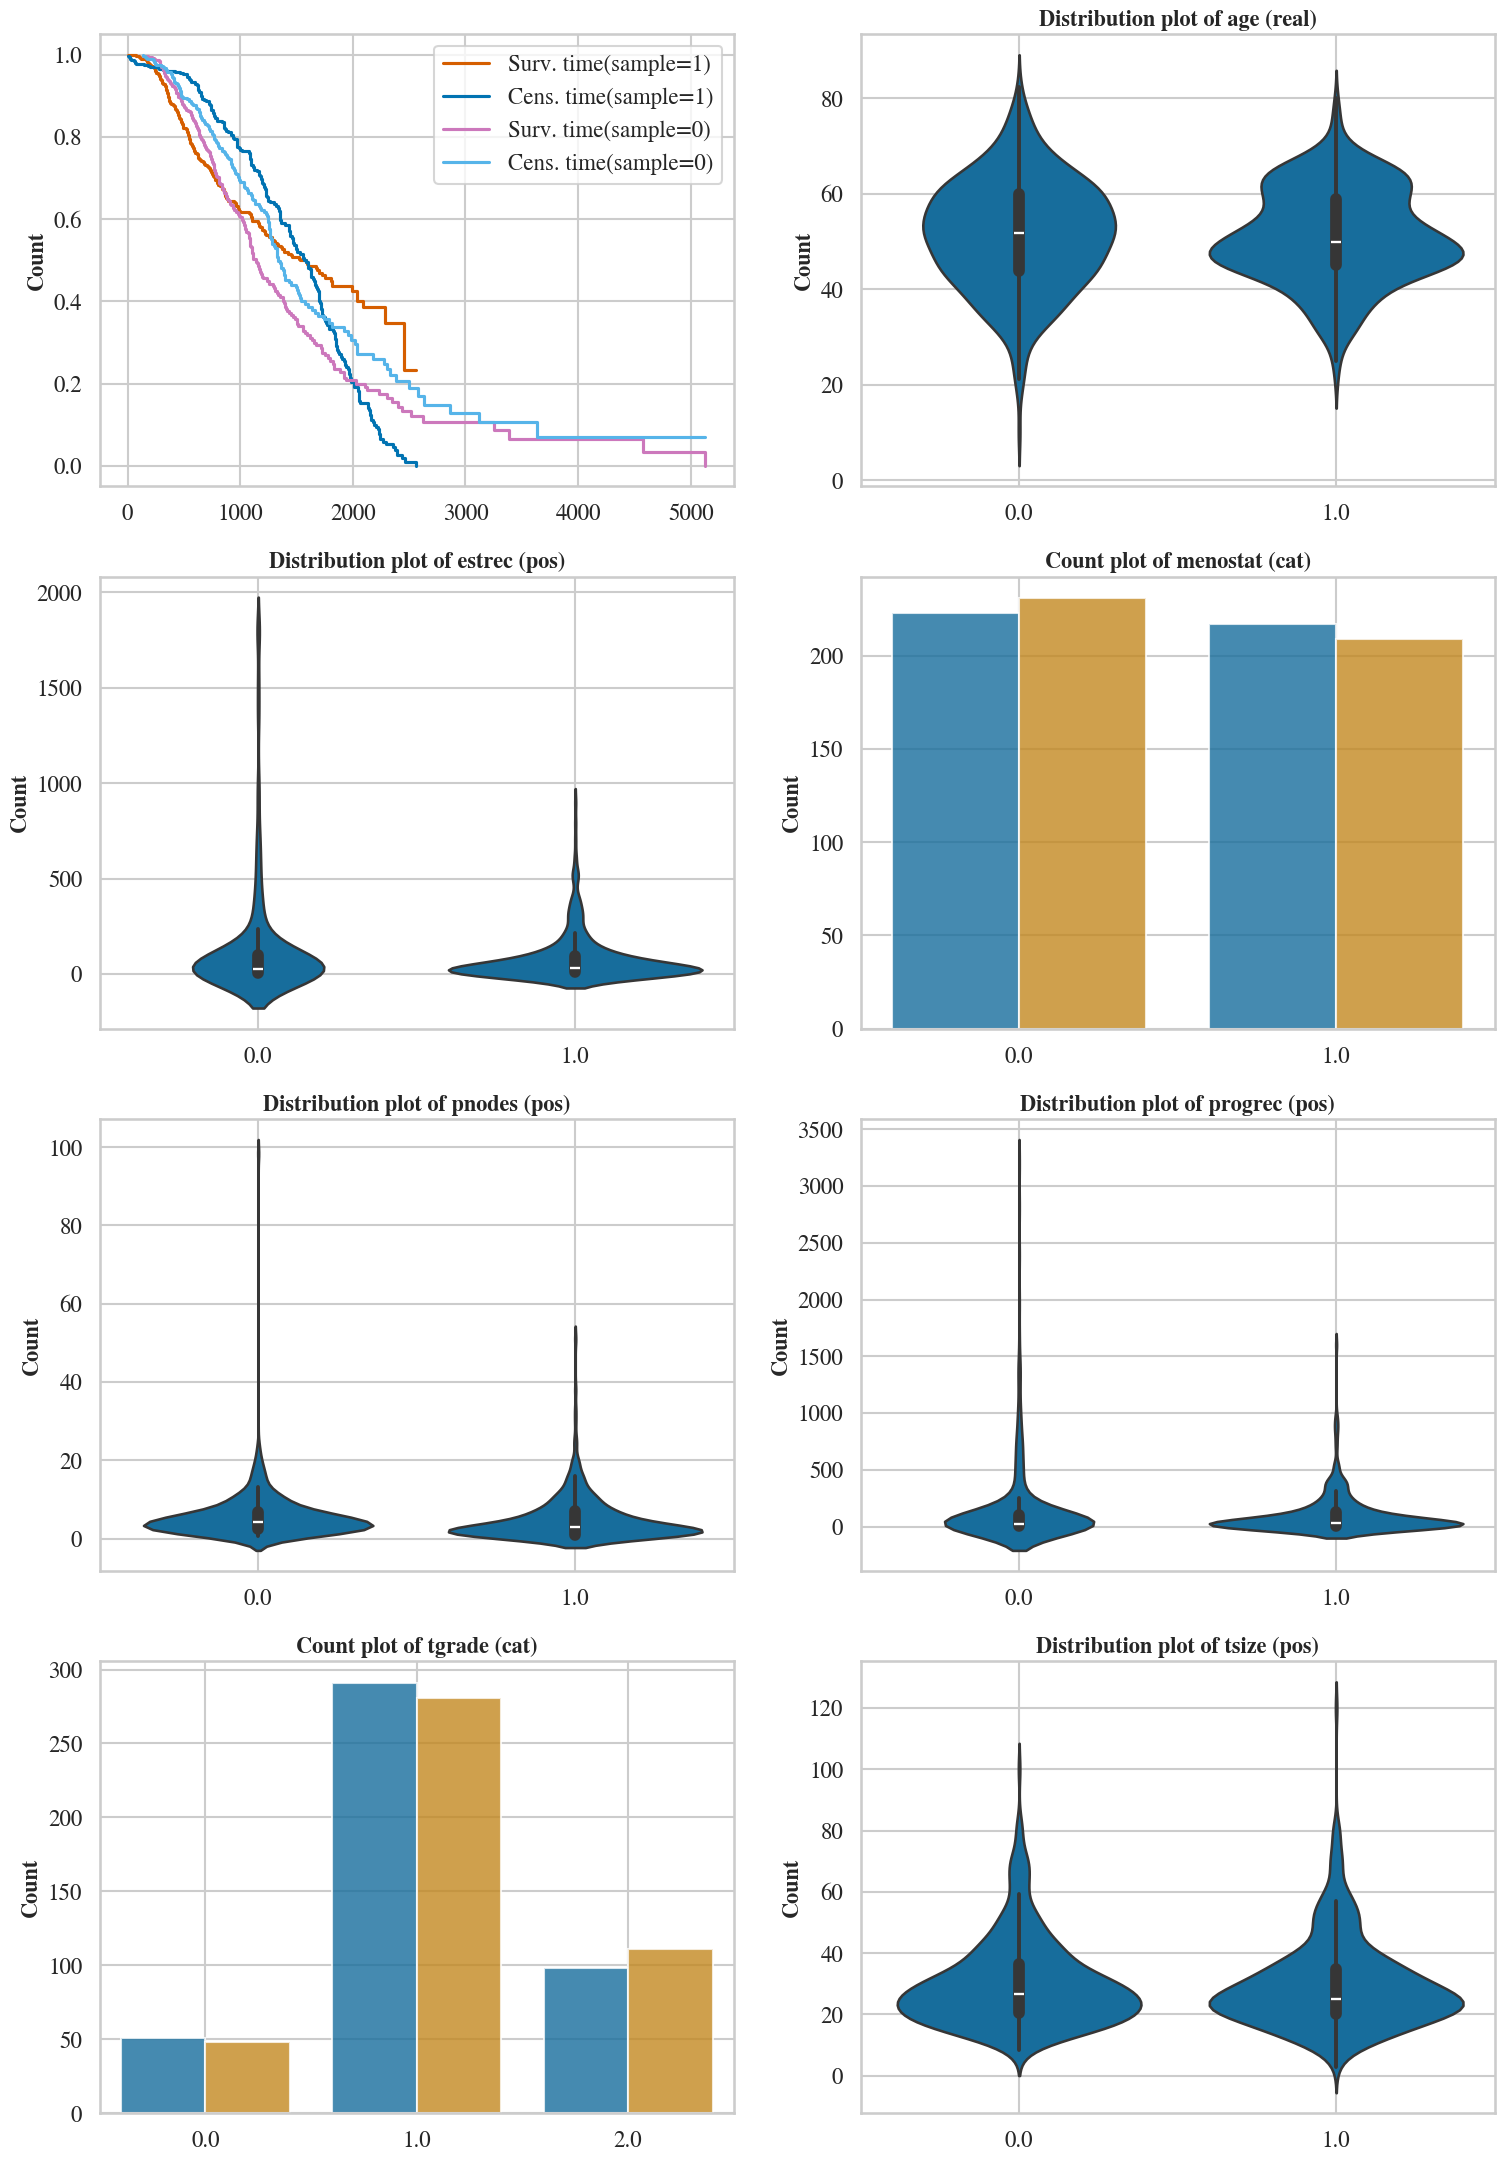

In [235]:
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_initial_generated.to_numpy(),feat_types_dict_all,feat_comparison_name = 'sample')

In [236]:
categorical = ['censor','menostat', 'tgrade','sample']
continuous = ['time', 'estrec', 'pnodes','progrec', 'tsize', 'age']
nonnormal = ['time', 'estrec', 'progrec', 'pnodes','tsize', 'age'] ## Doit-on mettre pnodes en nonnormal ?

In [237]:
table1 = TableOne(df_transformed_initial_generated, categorical=categorical, continuous=continuous, groupby='sample',nonnormal=nonnormal, pval=True)
print(table1)

                            Grouped by sample                                                                          
                                      Missing               Overall                     0                     1 P-Value
n                                                               880                   440                   440        
time, median [Q1,Q3]                        0  907.3 [558.4,1387.2]  874.2 [570.2,1262.1]  967.0 [547.8,1573.0]   0.069
censor, n (%)           0.0                              424 (48.2)            189 (43.0)            235 (53.4)   0.002
                        1.0                              456 (51.8)            251 (57.0)            205 (46.6)        
age, median [Q1,Q3]                         0      51.0 [44.0,59.4]      51.7 [43.8,59.9]      50.0 [45.0,59.0]   0.426
estrec, median [Q1,Q3]                      0       29.9 [7.4,94.2]       25.9 [7.2,99.8]       32.0 [8.0,92.2]   0.671
menostat, n (%)         0.0             

### Model loading

In [ ]:
import importlib
import os 

# model_name="HIVAE_factorized"
model_name="HIVAE_inputDropout"
dim_latent_z = 20
dim_latent_y = 15
dim_latent_s = 20
epochs = 1000
lr = 1e-3
save_file= "{}_{}_missing_{}_{}_z{}_y{}_s{}_batch_{}".format(model_name, dataset_name, m_perc, mask, dim_latent_z, dim_latent_y, dim_latent_s, batch_size)
# Create directories for saving models
save_dir = f'./saved_networks/{save_file}/'
os.makedirs(save_dir, exist_ok=True)
network_file = os.path.join(save_dir, f'{save_file}.pth')

# Create PyTorch HVAE model
model_loading = getattr(importlib.import_module("src"), model_name)
vae_model = model_loading(input_dim=data_train.shape[1], 
                          z_dim=dim_latent_z, 
                          y_dim=dim_latent_y, 
                          s_dim=dim_latent_s, 
                          y_dim_partition=None, 
                          feat_types_file=feat_types_file)

optimizer = optim.Adam(vae_model.parameters(), lr=lr)

### Train model

In [ ]:
feat_types_dict

In [ ]:
start_time = time.time()
loss_train, error_observed_train, error_missing_train = [], [], []
loss_val, error_observed_val, error_missing_val = [], [], []

rng = np.random.default_rng(seed=42)
for epoch in range(epochs):
    avg_loss, avg_KL_s, avg_KL_z = 0.0, 0.0, 0.0
    avg_loss_val, avg_KL_s_val, avg_KL_z_val = 0.0, 0.0, 0.0
    samples_list, p_params_list, q_params_list, log_p_x_total, log_p_x_missing_total = [], [], [], [], []
    tau = max(1.0 - 0.01 * epoch, 1e-3)

    # Shuffle training data
    perm = rng.permutation(data_train.shape[0])
    data_train = data_train[perm]
    miss_mask_train = miss_mask_train[perm]
    true_miss_mask_train = true_miss_mask_train[perm]

    for i in range(n_batches_train):
        # Get batch data
        data_list, miss_list = data_processing.next_batch(data_train, feat_types_dict, miss_mask_train, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]


        # Compute loss
        optimizer.zero_grad()
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau, n_generated_sample=1)
        vae_res["neg_ELBO_loss"].backward()
        optimizer.step()

        with torch.no_grad():

            avg_loss += vae_res["neg_ELBO_loss"].item() / n_batches_train
            avg_KL_s += torch.mean(vae_res["KL_s"]).item() / n_batches_train
            avg_KL_z += torch.mean(vae_res["KL_z"]).item() / n_batches_train
            # Number of samples generated by one input data

            

            
            for i in range(n_batches_test):
                data_list_test, miss_list_test = data_processing.next_batch(data_test, feat_types_dict, miss_mask_test, batch_test_size, i)
            
                # Mask unknown data (set unobserved values to zero)
                data_list_observed_test = [data * miss_list_test[:, i].view(batch_test_size, 1) for i, data in enumerate(data_list_test)]
            
                vae_res_test = vae_model.forward(data_list_observed_test, data_list_test, miss_list_test, tau=1e-3, n_generated_sample=1)
                avg_loss_val += vae_res_test["neg_ELBO_loss"].item() / n_batches_train
                avg_KL_s_val += torch.mean(vae_res_test["KL_s"]).item() / n_batches_train
                avg_KL_z_val += torch.mean(vae_res_test["KL_z"]).item() / n_batches_train
                #print(avg_loss_val)
            
            
     

        # Save the generated samlpes and estimated parameters !
        samples_list.append(vae_res["samples"])
        p_params_list.append(vae_res["p_params"])
        q_params_list.append(vae_res["q_params"])
        log_p_x_total.append(vae_res["log_p_x"])
        log_p_x_missing_total.append(vae_res["log_p_x_missing"])


    #Concatenate samples in arrays
    s_total, z_total, y_total, est_data_train = statistic.samples_concatenation(samples_list)
    
    # Transform discrete variables back to the original values
    data_train_transformed = data_processing.discrete_variables_transformation(data_train[: n_train_samples], feat_types_dict)
    est_data_train_transformed = data_processing.discrete_variables_transformation(est_data_train[0], feat_types_dict)
    # est_data_train_mean_imputed = statistic.mean_imputation(data_train_transformed, miss_mask_train[: n_train_samples], feat_types_dict)

    # Compute errors
    error_observed_samples, error_missing_samples = statistic.error_computation(data_train_transformed, est_data_train_transformed, 
                                                                                feat_types_dict, miss_mask[:n_train_samples])
    
    # # #Create global dictionary of the distribution parameters
    q_params_complete = statistic.q_distribution_params_concatenation(q_params_list)
    
    #Number of clusters created
    cluster_index = torch.argmax(q_params_complete['s'], 1)
    cluster = torch.unique(cluster_index)
    #print('Clusters: ' + str(len(cluster)))

    # Save average loss and error
    loss_train.append(avg_loss)
    loss_val.append(avg_loss_val)
    error_observed_train.append(torch.mean(error_observed_samples))
    error_missing_train.append(torch.mean(error_missing_samples))
    if epoch % 100 == 0:
        visualization.print_loss(epoch, start_time, -avg_loss, avg_KL_s, avg_KL_z)

print("Training finished.")

torch.save(vae_model.state_dict(), network_file)

visualization.plot_loss_evolution(-np.array(loss_train), title = "HI_VAE loss over epoch",
                                xlabel = "Epoch", ylabel = "ELBO")
visualization.plot_loss_evolution(-np.array(loss_val), title = "HI_VAE loss over epoch val",
                                xlabel = "Epoch", ylabel = "ELBO")


## Generated samples from control dataset

In [ ]:
data.shape

In [ ]:
data_forgen = data#[train_index]
miss_mask_forgen = miss_mask#[train_index]
true_miss_mask_forgen = true_miss_mask#[train_index]

In [ ]:
miss_mask_forgen.shape

In [ ]:
data_forgen.shape

#### Generate from original sample

In [ ]:
n_samples_forgen = data_forgen.shape[0]
batch_size = n_samples_forgen
print(n_samples_forgen)
# Number of batches
n_batches_generation = 1

# Compute real missing mask
miss_mask_forgen = torch.multiply(miss_mask_forgen, true_miss_mask_forgen)

# Number of samples generated by one input data
n_generated_sample = 100

with torch.no_grad(): 
    
    error_mode_global = 0.0
    avg_loss = 0.0
    samples_list = []
    
    for i in range(n_batches_generation):
        data_list, miss_list = data_processing.next_batch(data_forgen, feat_types_dict, miss_mask_forgen, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]
        
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau=1e-3, n_generated_sample=n_generated_sample)
        samples_list.append(vae_res["samples"])
    
    
    #Concatenate samples in arrays
    est_data_gen = statistic.samples_concatenation(samples_list)[-1]
    est_data_gen_transformed = []
    for j in range(n_generated_sample):
        data_trans = data_processing.discrete_variables_transformation(est_data_gen[j], feat_types_dict)
        data_trans = data_processing.survival_variables_transformation(data_trans,feat_types_dict)
        est_data_gen_transformed.append(data_trans.unsqueeze(0))
        
    est_data_gen_transformed = torch.cat(est_data_gen_transformed, dim=0)

### Statistical analysis with simulated vs initial control data

In [ ]:
df_transformed_initial = pd.DataFrame(data_transformed_control.numpy(), columns=gbsb2_control_columns)
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[3].numpy(), columns=gbsb2_control_columns)
df_transformed_initial["sample"]=1
df_transformed_generated["sample"]=0
df_transformed_initial_generated = pd.concat([df_transformed_initial, df_transformed_generated], ignore_index=True)

In [ ]:
df_transformed_generated

In [ ]:
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_initial_generated.to_numpy(),feat_types_dict_all,feat_comparison_name = 'sample')

In [ ]:
categorical = ['censor','menostat', 'tgrade','sample']
continuous = ['time', 'estrec', 'pnodes','progrec', 'tsize', 'age']
nonnormal = ['time', 'estrec', 'progrec', 'pnodes','tsize', 'age'] ## Doit-on mettre pnodes en nonnormal ?

In [ ]:
table1 = TableOne(df_transformed_initial_generated, categorical=categorical, continuous=continuous, groupby='sample',nonnormal=nonnormal, pval=True)
print(table1)

### Statistical analysis: generated control x initial treated

In [ ]:
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[2].numpy(), columns=gbsb2_control_columns)
df_transformed_generated['treatment'] = 0
df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
#df_transformed_T_Cgen = df_transformed_T_Cgen.drop('sample',axis=1)
#df_transformed_T_Cgen.head()

In [ ]:
categorical = ['censor','menostat', 'tgrade','treatment']
continuous = ['time', 'estrec', 'pnodes','progrec', 'tsize', 'age']
nonnormal = ['time', 'estrec', 'progrec', 'pnodes','tsize', 'age'] ## Doit-on mettre pnodes en nonnormal ?
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

In [ ]:
table1 = TableOne(df_transformed_T_Cgen, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

In [ ]:

time_initial_C, survival_prob_initial_C, conf_int_initial_C = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_all[df_transformed_all['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_initial_T, survival_prob_initial_T, conf_int_initial_T = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_all[df_transformed_all['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)

time_T_Cgen_C, survival_prob_T_Cgen_C, conf_int_T_Cgen_C = kaplan_meier_estimator(
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_T_Cgen_T, survival_prob_T_Cgen_T, conf_int_T_Cgen_T = kaplan_meier_estimator(
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)


plt.step(time_initial_C, survival_prob_initial_C, where="post", label="Initial Control Group")
plt.fill_between(time_initial_C, conf_int_initial_C[0], conf_int_initial_C[1], alpha=0.25, step="post")

plt.step(time_initial_T, survival_prob_initial_T, where="post", label="Treatment Group")
plt.fill_between(time_initial_T, conf_int_initial_T[0], conf_int_initial_T[1], alpha=0.25, step="post")


plt.step(time_T_Cgen_C, survival_prob_T_Cgen_C, where="post", label="Generated Control Group")
plt.fill_between(time_T_Cgen_C, conf_int_T_Cgen_C[0], conf_int_T_Cgen_C[1], alpha=0.25, step="post")


#plt.step(time_T_Cgen_T, survival_prob_T_Cgen_T, where="post")
#plt.fill_between(time_T_Cgen_T, conf_int_T_Cgen_T[0], conf_int_T_Cgen_T[1], alpha=0.25, step="post")

plt.ylim(0, 1)

# Add legend
plt.legend()

# Optional: add axis labels and title
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Curves with Confidence Intervals")

# Show the plot
plt.show()

## Tests

In [ ]:
categorical_encode = ['censor','menostat', 'tgrade','treatment']

In [ ]:
df_transformed_all

In [ ]:
df_transformed_all_oh = df_transformed_all.copy()
for feat in categorical_encode:
    df_transformed_all_oh = data_processing.encode_and_bind(df_transformed_all_oh,feat)
X_initial = df_transformed_all_oh.to_numpy()[:,2:15]
Y_initial = Surv.from_arrays(df_transformed_all_oh.to_numpy()[:,1]==1,df_transformed_all_oh.to_numpy()[:,0])    

In [ ]:
number_column_treatment = 8 # in X_initial

In [ ]:
cox_initial = CoxPHSurvivalAnalysis()
cox_initial.fit(X_initial,Y_initial)
cox_initial.coef_

In [ ]:
coef_treat = np.zeros((n_generated_sample,cox_initial.coef_.shape[0] + 1))
for i in np.arange(n_generated_sample):
    #print(i)
    df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=gbsb2_control_columns)
    df_transformed_generated['treatment'] = 0
    df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
    df_transformed_T_Cgen_oh = df_transformed_T_Cgen.copy()
    for feat in categorical_encode:
        df_transformed_T_Cgen_oh = data_processing.encode_and_bind(df_transformed_T_Cgen_oh,feat)
    
    X_T_Cgen = df_transformed_T_Cgen_oh.to_numpy()[:,2:15]
    Y_T_Cgen = Surv.from_arrays(df_transformed_T_Cgen_oh.to_numpy()[:,1]==1,df_transformed_T_Cgen_oh.to_numpy()[:,0])
    coef_treat[i,0] = -np.log(compare_survival(Y_T_Cgen,X_T_Cgen[:,number_column_treatment])[1])
    cox_generated = CoxPHSurvivalAnalysis()
    cox_generated.fit(X_T_Cgen,Y_T_Cgen)
    coef_treat[i,1:] = cox_generated.coef_[:]


In [ ]:
df_transformed_all_oh.columns

In [ ]:
# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1+np.arange(coef_treat.shape[1])  # X-axis positions of violins
y_values = np.zeros(coef_treat.shape[1])
y_values[0] = -np.log(compare_survival(Y_initial,X_initial[:,number_column_treatment])[1])
y_values[1:] = cox_initial.coef_[:]  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(1+np.arange(coef_treat.shape[1]))
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticklabels(['LR','age', 'estrec', 'menostat', 'pnodes', 'progrec', 'tsize', 'treatment', 'tgrade1.0', 'tgrade2.0'])
ax.set_ylabel("Values")
ax.set_ylim(-0.5, 1) #to zoom on treatment values
ax.legend()

plt.show()

### Log rank test

In [ ]:
plt.violinplot(coef_treat[:,0])#,
plt.hlines(y_values[0],0.8,1.2,color='green')
plt.hlines(-np.log(0.05),0.8,1.2,color='red')

### Test coefficient traitement (Cox)

In [ ]:
plt.violinplot(coef_treat[:,number_column_treatment+1])#,
plt.hlines(y_values[7],0.8,1.2,color='green')

### Statistical analysis with original data

In [ ]:
gbsg2_control = pd.read_csv(data_file_control,header=None)

gbsg2_control.columns = gbsb2_control_columns
gbsg2_control.head()

In [ ]:
np.quantile(gbsg2_control[gbsg2_control['censor']==1]['time'],0.95)

### Data loading and Feature analysis treated/control

In [ ]:
# Load training data
data_control, feat_types_dict, miss_mask_control, true_miss_mask_control, n_samples_control = data_processing.read_data(data_file_control, 
                                                                                                                        feat_types_file_control, 
                                                                                                                        miss_file, true_miss_file)
# Feature analysis
data_transformed_control = data_processing.discrete_variables_transformation(data_control, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

visualization.plot_data(data_transformed_control, feat_types_dict)


In [ ]:
feat_types_dict[3]#['name']


In [ ]:
gbsg2_control = pd.read_csv(data_file_control,header=None)

gbsg2_control.columns = gbsb2_control_columns
gbsg2_control.head()

In [ ]:
# Load training data
data_treated, feat_types_dict, miss_mask_treated, true_miss_mask_treated, n_samples_treated = data_processing.read_data(data_file_treated, 
                                                                                                                        feat_types_file_control, 
                                                                                                                        miss_file, true_miss_file)

# Feature analysis
data_transformed_treated = data_processing.discrete_variables_transformation(data_treated, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

visualization.plot_data(data_transformed_treated, feat_types_dict)

In [ ]:
df_transformed_treated = pd.DataFrame(data_transformed_treated.numpy(), columns=gbsb2_control_columns)
df_transformed_control = pd.DataFrame(data_transformed_control.numpy(), columns=gbsb2_control_columns)
df_transformed_treated["treatment"]=1
df_transformed_control["treatment"]=0
df_transformed_all = pd.concat([df_transformed_control, df_transformed_treated], ignore_index=True)

In [ ]:
df_transformed_all.columns

In [ ]:
categorical = []
continuous = []
nonnormal = []
for index, row in pd.read_csv(feat_types_file_control).iterrows():
    if row['type'] == 'cat':
        categorical.append(row['name'])
    elif row['type'] in ['real','pos','count']:
        continuous.append(row['name'])
        if row['type'] in ['pos','count']:
            nonnormal.append(row['name'])
categorical.append('censor')
categorical.append('treatment')
continuous.append('time')
nonnormal.append('time')

In [ ]:
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

### Experiment setting

In [ ]:
# Train-test split on control
data = data_control
miss_mask = miss_mask_control
true_miss_mask = true_miss_mask_control
feat_types_file = feat_types_file_control
train_test_share = .9
n_samples = data.shape[0]
n_train_samples = int(train_test_share * n_samples)
train_index = np.random.choice(n_samples, n_train_samples, replace=False)
test_index = [i for i in np.arange(n_samples) if i not in train_index]

data_train = data[train_index]
miss_mask_train = miss_mask[train_index]
true_miss_mask_train = true_miss_mask[train_index]

data_test = data[test_index]
miss_mask_test = miss_mask[test_index]
true_miss_mask_test = true_miss_mask[test_index]

# Adjust batch size if larger than dataset
batch_size = 100
batch_size = min(batch_size, n_train_samples)

# Number of batches
n_train_samples = data_train.shape[0]
n_batches_train = int(np.floor(n_train_samples / batch_size))
n_train_samples = n_batches_train * batch_size

# Compute real missing mask
miss_mask_train = torch.multiply(miss_mask_train, true_miss_mask_train)

# On test/val
n_test_samples = data_test.shape[0]
# Adjust batch size if larger than dataset
batch_test_size = n_test_samples
# Number of batches
n_batches_test = int(np.floor(n_test_samples / batch_test_size))

# Compute real missing mask
miss_mask_test = torch.multiply(miss_mask_test, true_miss_mask_test)
n_generated_sample = 10

### Model loading

In [ ]:
import importlib
import os 

# model_name="HIVAE_factorized"
model_name="HIVAE_inputDropout"
dim_latent_z = 20
dim_latent_y = 15
dim_latent_s = 20
epochs = 1000
lr = 1e-3
save_file= "{}_{}_missing_{}_{}_z{}_y{}_s{}_batch_{}".format(model_name, dataset_name, m_perc, mask, dim_latent_z, dim_latent_y, dim_latent_s, batch_size)
# Create directories for saving models
save_dir = f'./saved_networks/{save_file}/'
os.makedirs(save_dir, exist_ok=True)
network_file = os.path.join(save_dir, f'{save_file}.pth')

# Create PyTorch HVAE model
model_loading = getattr(importlib.import_module("src"), model_name)
vae_model = model_loading(input_dim=data_train.shape[1], 
                          z_dim=dim_latent_z, 
                          y_dim=dim_latent_y, 
                          s_dim=dim_latent_s, 
                          y_dim_partition=None, 
                          feat_types_file=feat_types_file)

optimizer = optim.Adam(vae_model.parameters(), lr=lr)

### Train model

In [ ]:
feat_types_dict

In [ ]:
start_time = time.time()
loss_train, error_observed_train, error_missing_train = [], [], []
loss_val, error_observed_val, error_missing_val = [], [], []

for epoch in range(epochs):
    avg_loss, avg_KL_s, avg_KL_z = 0.0, 0.0, 0.0
    avg_loss_val, avg_KL_s_val, avg_KL_z_val = 0.0, 0.0, 0.0
    samples_list, p_params_list, q_params_list, log_p_x_total, log_p_x_missing_total = [], [], [], [], []
    tau = max(1.0 - 0.01 * epoch, 1e-3)

    # Shuffle training data
    perm = np.random.permutation(data_train.shape[0])
    data_train = data_train[perm]
    miss_mask_train = miss_mask_train[perm]
    true_miss_mask_train = true_miss_mask_train[perm]

    for i in range(n_batches_train):
        # Get batch data
        data_list, miss_list = data_processing.next_batch(data_train, feat_types_dict, miss_mask_train, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]


        # Compute loss
        optimizer.zero_grad()
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau, n_generated_sample=1)
        vae_res["neg_ELBO_loss"].backward()
        optimizer.step()

        with torch.no_grad():

            avg_loss += vae_res["neg_ELBO_loss"].item() / n_batches_train
            avg_KL_s += torch.mean(vae_res["KL_s"]).item() / n_batches_train
            avg_KL_z += torch.mean(vae_res["KL_z"]).item() / n_batches_train

            
            for i in range(n_batches_test):
                data_list_test, miss_list_test = data_processing.next_batch(data_test, feat_types_dict, miss_mask_test, batch_test_size, i)
            
                # Mask unknown data (set unobserved values to zero)
                data_list_observed_test = [data * miss_list_test[:, i].view(batch_test_size, 1) for i, data in enumerate(data_list_test)]
            
                vae_res_test = vae_model.forward(data_list_observed_test, data_list_test, miss_list_test, tau=1e-3, n_generated_sample=1)
                avg_loss_val += vae_res_test["neg_ELBO_loss"].item() / n_batches_train
                avg_KL_s_val += torch.mean(vae_res_test["KL_s"]).item() / n_batches_train
                avg_KL_z_val += torch.mean(vae_res_test["KL_z"]).item() / n_batches_train
                #print(avg_loss_val)
            
            
     

        # Save the generated samlpes and estimated parameters !
        samples_list.append(vae_res["samples"])
        p_params_list.append(vae_res["p_params"])
        q_params_list.append(vae_res["q_params"])
        log_p_x_total.append(vae_res["log_p_x"])
        log_p_x_missing_total.append(vae_res["log_p_x_missing"])


    #Concatenate samples in arrays
    s_total, z_total, y_total, est_data_train = statistic.samples_concatenation(samples_list)
    
    # Transform discrete variables back to the original values
    data_train_transformed = data_processing.discrete_variables_transformation(data_train[: n_train_samples], feat_types_dict)
    est_data_train_transformed = data_processing.discrete_variables_transformation(est_data_train[0], feat_types_dict)
    # est_data_train_mean_imputed = statistic.mean_imputation(data_train_transformed, miss_mask_train[: n_train_samples], feat_types_dict)

    # Compute errors
    error_observed_samples, error_missing_samples = statistic.error_computation(data_train_transformed, est_data_train_transformed, feat_types_dict, miss_mask[:n_train_samples])
    
    # # #Create global dictionary of the distribution parameters
    q_params_complete = statistic.q_distribution_params_concatenation(q_params_list)
    
    #Number of clusters created
    cluster_index = torch.argmax(q_params_complete['s'], 1)
    cluster = torch.unique(cluster_index)
    #print('Clusters: ' + str(len(cluster)))

    # Save average loss and error
    loss_train.append(avg_loss)
    loss_val.append(avg_loss_val)
    error_observed_train.append(torch.mean(error_observed_samples))
    error_missing_train.append(torch.mean(error_missing_samples))

    if epoch % 100 == 0:
        visualization.print_loss(epoch, start_time, -avg_loss, avg_KL_s, avg_KL_z)
        visualization.print_loss(epoch, start_time, -avg_loss_val, avg_KL_s_val, avg_KL_z_val)



print("Training finished.")

torch.save(vae_model.state_dict(), network_file)

visualization.plot_loss_evolution(-np.array(loss_train), title = "HI_VAE loss over epoch",
                                xlabel = "Epoch", ylabel = "ELBO")
visualization.plot_loss_evolution(-np.array(loss_val), title = "HI_VAE loss over epoch val",
                                xlabel = "Epoch", ylabel = "ELBO")


In [ ]:
len(data_list)

In [ ]:
miss_list.shape

### Visualize the generated samples

In [ ]:
data.shape

### Statistical analysis with simulated data

In [ ]:
data_forgen = data#[train_index]
miss_mask_forgen = miss_mask#[train_index]
true_miss_mask_forgen = true_miss_mask#[train_index]

In [ ]:
miss_mask_forgen.shape

In [ ]:
data_forgen.shape

#### Generate from original sample

In [ ]:
n_samples_forgen = data_forgen.shape[0]
batch_size = n_samples_forgen
print(n_samples_forgen)
# Number of batches
n_batches_generation = 1

# Compute real missing mask
miss_mask_forgen = torch.multiply(miss_mask_forgen, true_miss_mask_forgen)

# Number of samples generated by one input data
n_generated_sample = 10

with torch.no_grad(): 
    
    error_mode_global = 0.0
    avg_loss = 0.0
    samples_list = []
    
    for i in range(n_batches_generation):
        data_list, miss_list = data_processing.next_batch(data_forgen, feat_types_dict, miss_mask_forgen, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]
        
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau=1e-3, n_generated_sample=n_generated_sample)
        samples_list.append(vae_res["samples"])
    
    
    #Concatenate samples in arrays
    est_data_gen = statistic.samples_concatenation(samples_list)[-1]
    est_data_gen_transformed = []
    for j in range(n_generated_sample):
        data_trans = data_processing.discrete_variables_transformation(est_data_gen[j], feat_types_dict)
        data_trans = data_processing.survival_variables_transformation(data_trans,feat_types_dict)
        est_data_gen_transformed.append(data_trans.unsqueeze(0))
        
    est_data_gen_transformed = torch.cat(est_data_gen_transformed, dim=0)

In [ ]:
# Call plotting function
visualization.plot_data(est_data_gen_transformed[5], feat_types_dict)


In [ ]:
df_transformed_initial = pd.DataFrame(data_transformed_control.numpy(), columns=gbsb2_control_columns)
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[0].numpy(), columns=gbsb2_control_columns)
df_transformed_initial["sample"]=1
df_transformed_generated["sample"]=0
df_transformed_initial_generated = pd.concat([df_transformed_initial, df_transformed_generated], ignore_index=True)

In [ ]:
categorical = []
continuous = []
nonnormal = []
for index, row in pd.read_csv(feat_types_file_control).iterrows():
    if row['type'] == 'cat':
        categorical.append(row['name'])
    elif row['type'] in ['real','pos','count']:
        continuous.append(row['name'])
        if row['type'] in ['pos','count']:
            nonnormal.append(row['name'])
categorical.append('censor')
categorical.append('treatment')
continuous.append('time')
nonnormal.append('time')

categorical.remove('treatment')
categorical.append('sample')

In [ ]:
table1 = TableOne(df_transformed_initial_generated, categorical=categorical, continuous=continuous, groupby='sample',nonnormal=nonnormal, pval=True)
print(table1)

In [ ]:
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[3].numpy(), columns=gbsb2_control_columns)
df_transformed_generated['treatment'] = 0
df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
#df_transformed_T_Cgen = df_transformed_T_Cgen.drop('sample',axis=1)
#df_transformed_T_Cgen.head()

In [ ]:
#df_transformed_all.head()

In [ ]:
categorical.append('treatment')
categorical.remove('sample')
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

In [ ]:
table1 = TableOne(df_transformed_T_Cgen, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

In [ ]:
df_transformed_all.head()

In [ ]:

time_initial_C, survival_prob_initial_C, conf_int_initial_C = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==0]['censor'].to_numpy()==1, 
    df_transformed_all[df_transformed_all['treatment']==0]['time'].to_numpy(), conf_type="log-log"
)

time_initial_T, survival_prob_initial_T, conf_int_initial_T = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==1]['censor'].to_numpy()==1, 
    df_transformed_all[df_transformed_all['treatment']==1]['time'].to_numpy(), conf_type="log-log"
)

time_T_Cgen_C, survival_prob_T_Cgen_C, conf_int_T_Cgen_C = kaplan_meier_estimator(
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0]['censor'].to_numpy()==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0]['time'].to_numpy(), conf_type="log-log"
)

time_T_Cgen_T, survival_prob_T_Cgen_T, conf_int_T_Cgen_T = kaplan_meier_estimator(
   df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1]['censor'].to_numpy()==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1]['time'].to_numpy(), conf_type="log-log"
)


plt.step(time_initial_C, survival_prob_initial_C, where="post")
plt.fill_between(time_initial_C, conf_int_initial_C[0], conf_int_initial_C[1], alpha=0.25, step="post")

plt.step(time_initial_T, survival_prob_initial_T, where="post")
plt.fill_between(time_initial_T, conf_int_initial_T[0], conf_int_initial_T[1], alpha=0.25, step="post")


plt.step(time_T_Cgen_C, survival_prob_T_Cgen_C, where="post")
plt.fill_between(time_T_Cgen_C, conf_int_T_Cgen_C[0], conf_int_T_Cgen_C[1], alpha=0.25, step="post")


#plt.step(time_T_Cgen_T, survival_prob_T_Cgen_T, where="post")
#plt.fill_between(time_T_Cgen_T, conf_int_T_Cgen_T[0], conf_int_T_Cgen_T[1], alpha=0.25, step="post")

plt.ylim( 0,1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [ ]:
df_transformed_all

In [ ]:
list_cov

In [ ]:
def encode_and_bind(original_dataframe, feature_to_encode):
    #print(np.unique(original_dataframe[feature_to_encode]))#.shape[0])
    if np.unique(original_dataframe[feature_to_encode]).shape[0] > 2 :
        dummies = pd.get_dummies(original_dataframe[feature_to_encode],drop_first=True, prefix=feature_to_encode, prefix_sep='',dtype=int)
        res = pd.concat([original_dataframe, dummies], axis=1)
        #print(res.head())
        res = res.drop([feature_to_encode], axis=1)
    else:
        res = original_dataframe
    return(res) 

categorical_encode = ['menostat', 'tgrade','treatment']


In [ ]:
df_transformed_all_oh = df_transformed_all.copy()
for feat in categorical_encode:
    df_transformed_all_oh = encode_and_bind(df_transformed_all_oh,feat)

In [ ]:
df_transformed_all_oh.head()

In [ ]:
X_initial = np.delete(df_transformed_all_oh.to_numpy(),[6,7],axis=1)
Y_initial = Surv.from_arrays(df_transformed_all_oh.to_numpy()[:,7]==1,df_transformed_all.to_numpy()[:,6])
print(compare_survival(Y_initial,X_initial[:,6]))
for i in np.arange(n_generated_sample):
    df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=gbsb2_control_columns)
    df_transformed_generated['treatment'] = 0
    df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
    df_transformed_T_Cgen_oh = df_transformed_T_Cgen.copy()
    for feat in categorical_encode:
        df_transformed_T_Cgen_oh = encode_and_bind(df_transformed_T_Cgen_oh,feat)
    
    X_T_Cgen = np.delete(df_transformed_T_Cgen_oh.to_numpy(),[6,7],axis=1)
    Y_T_Cgen = Surv.from_arrays(df_transformed_T_Cgen_oh.to_numpy()[:,7]==1,df_transformed_T_Cgen_oh.to_numpy()[:,6])
    print(compare_survival(Y_T_Cgen,X_T_Cgen[:,6]))

In [ ]:
# Fit the Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(df_transformed_all_oh, duration_col='time', event_col='censor')

# Display summary statistics of the model
cph.print_summary()

In [ ]:
for i in np.arange(n_generated_sample):
    df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=gbsb2_control_columns)
    df_transformed_generated['treatment'] = 0
    df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
    df_transformed_T_Cgen_oh = df_transformed_T_Cgen.copy()
    for feat in categorical_encode:
        df_transformed_T_Cgen_oh = encode_and_bind(df_transformed_T_Cgen_oh,feat)
    cph_g = CoxPHFitter()
    cph_g.fit(df_transformed_T_Cgen_oh, duration_col='time', event_col='censor')

    # Display summary statistics of the model
    print(cph_g.print_summary())
    

In [ ]:
#df_transformed_all.columns


In [ ]:
cox_initial = CoxPHSurvivalAnalysis()
cox_initial.fit(X_initial,Y_initial)
cox_initial.coef_

In [ ]:
df_transformed_T_Cgen.head()

In [ ]:
df_transformed_T_Cgen.head()

In [ ]:
print(compare_survival(Y_T_Cgen,X_T_Cgen[:,-1]))

In [ ]:
df_transformed_all[df_transformed_all['treatment']==0].head()

In [ ]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']
continuous = ['time', 'cd4',   'priorzdv', 'age']
nonnormal = ['time', 'cd4',   'priorzdv']
table1 = TableOne(df_transformed_T_Cgen, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

In [ ]:
print(compare_survival(Y_gen,X_gen[:,0]))

In [ ]:
cox_T_Cgen = CoxPHSurvivalAnalysis()
cox_T_Cgen.fit(X_T_Cgen,Y_T_Cgen)
cox_T_Cgen.coef_

In [ ]:
df_transformed_initial = pd.DataFrame(data_transformed_control.numpy(), columns=aids_control_columns)
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[0].numpy(), columns=aids_control_columns)
df_transformed_initial["sample"]=1
df_transformed_generated["sample"]=0
df_transformed_all = pd.concat([df_transformed_initial, df_transformed_generated], ignore_index=True)

In [ ]:
cox_gen = CoxPHSurvivalAnalysis()
cox_gen.fit(X_gen,Y_gen)
cox_gen.coef_

In [ ]:
coef_treat = np.zeros((n_generated_sample,cox_initial.coef_.shape[0] + 1))
for i in np.arange(n_generated_sample):
    print(i)
    X_gen = est_data_gen_transformed[i].numpy()[:,2:10]
    Y_gen = Surv.from_arrays(est_data_gen_transformed[i].numpy()[:,1]==1,est_data_gen_transformed[i].numpy()[:,0])
    coef_treat[i,0] = compare_survival(Y_gen,X_gen[:,0])[1]
    cox_generated = CoxPHSurvivalAnalysis()
    cox_generated.fit(X_gen,Y_gen)
    coef_treat[i,1:] = cox_generated.coef_[:]

In [ ]:
n_generated_sample

In [ ]:


# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1 + np.arange(coef_treat.shape[1])  # X-axis positions of violins
y_values = coef_initial  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(np.arange(coef_treat.shape[1]))
#ax.set_xticklabels()
ax.set_ylabel("Values")
ax.legend()

plt.show()